In [7]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [8]:
import os
import tempfile
# Use system temp directory for caching
cache_dir = os.path.join(tempfile.gettempdir(), "f1_cache")
os.makedirs(cache_dir, exist_ok=True)

fastf1.Cache.enable_cache(cache_dir)

In [9]:
# load the 2024 Zandvoort session data
session_2024 = fastf1.get_session(2024, 15, "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']


In [10]:
# covert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
        laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

In [19]:
Sector_times_2024=laps_2024.groupby("Driver").agg({
    "Sector1Time (s)":"mean",
    "Sector2Time (s)":"mean",
    "Sector3Time (s)":"mean"

}).reset_index()

Sector_times_2024["TotalSectorTime (s)"] = (
    Sector_times_2024["Sector1Time (s)"] +
    Sector_times_2024["Sector2Time (s)"] +
    Sector_times_2024["Sector3Time (s)"]
)


In [20]:
# clean air race pace from racepace.py
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}

In [26]:
# quali data from Venderoot GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [  
        69.673,  # NOR(1:09.673)
        70.029,  # Ver 
        70.172,  # PIA (1:10.129)
        70.244,    # RUS 
        70.416,  # Perez
        70.582,  # LEC
        70.663,  # Alo 
        71.995,  # OCO (1:10.942)
        70.948,  # HAM (1:10.382)
        70.661,  # STR (1:12.563)
        70.815,  # GAS (1:11.994)
        None,  # albon
        71.215   # HUL (1:11.596)
    ]
})
qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)

In [27]:
#get weather data for Netherlands
API_KEY = "d2585e28290357a9db05c428cdb49ae9"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=52.3711&lon=4.5334&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()
forecast_time = "2025-08-31 13:00:00"  # 15:00 CEST local time
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)
rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20



In [28]:
# adjust qualifying time based on weather conditions
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]


In [29]:
# add constructor's data
team_points = {
    "McLaren": 279, "Mercedes": 147, "Red Bull": 131, "Williams": 51, "Ferrari": 114,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 10, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)


In [30]:
# average position change at Zandervoot (quali pos - finish pos); positive means losing positions
average_position_change_Zandervoot = {
    "VER": -1.0,  
    "NOR": 1.0,
    "PIA": 0.2,
    "RUS": 0.5,
    "SAI": -0.3,
    "ALB": 0.8,
    "LEC": -1.5, 
    "OCO": -0.2,
    "HAM": 0.3,
    "STR": 1.1,
    "GAS": -0.4,
    "ALO": -0.6,
    "HUL": 0.0
}
qualifying_2025["AveragePositionChange"] = qualifying_2025["Driver"].map(average_position_change_Zandervoot)


In [31]:
# merge qualifying and sector times data
merged_data = qualifying_2025.merge(Sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]
valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers]


In [32]:
# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore", 
    "CleanAirRacePace (s)", "AveragePositionChange"
]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])


In [33]:
# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

In [34]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)


In [35]:
# train gradient boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.7, max_depth=3, random_state=37)
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)

In [37]:
# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")
print("\n🏁 Predicted 2025 Zandervoot GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime (s)"]])
y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")


🏁 Predicted 2025 Zandervoot GP Winner 🏁

   Driver  PredictedRaceTime (s)
6     LEC              75.882197
0     VER              75.894366
2     PIA              75.918563
8     HAM              76.166732
1     NOR              76.174536
3     RUS              76.174746
10    GAS              76.706700
7     OCO              76.754792
11    ALO              76.776086
12    HUL              76.832871
9     STR              76.858423
4     SAI              77.013660
5     ALB              77.109929
Model Error (MAE): 0.53 seconds


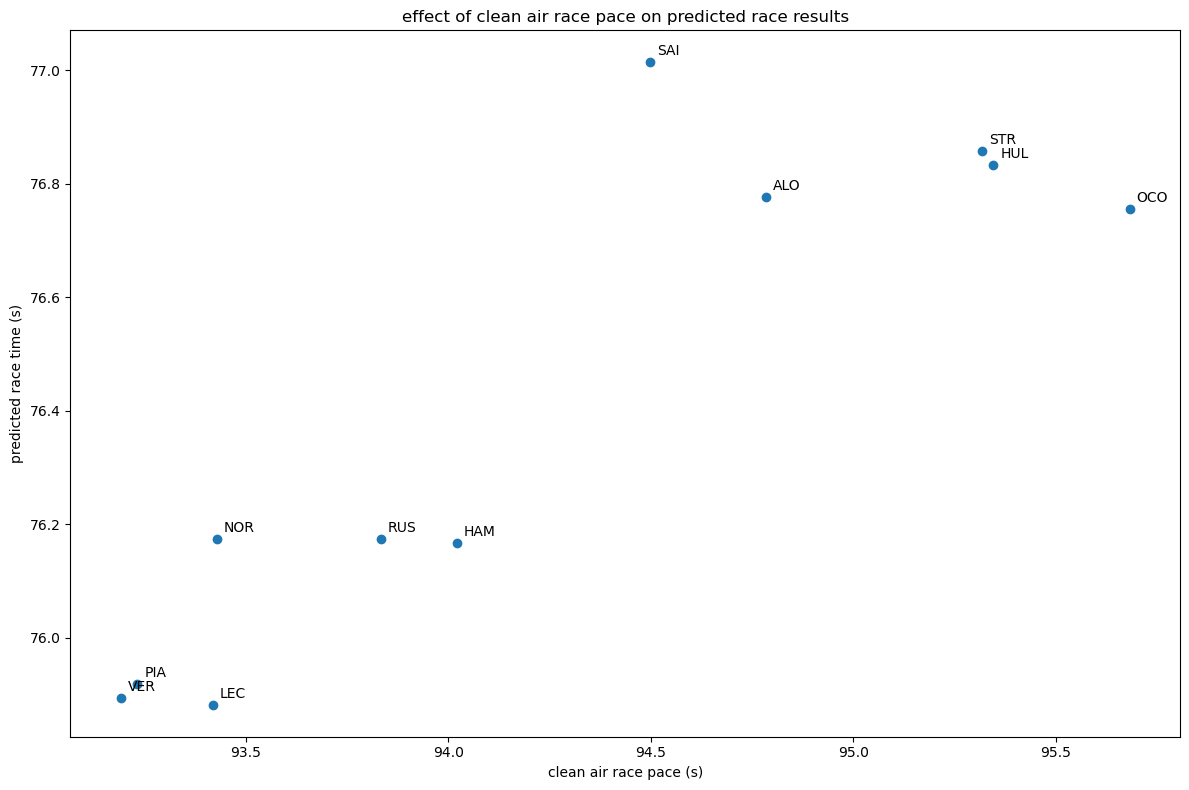

In [38]:
# plot effect of clean air race pace
plt.figure(figsize=(12, 8))
plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedRaceTime (s)"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel("clean air race pace (s)")
plt.ylabel("predicted race time (s)")
plt.title("effect of clean air race pace on predicted race results")
plt.tight_layout()
plt.show()

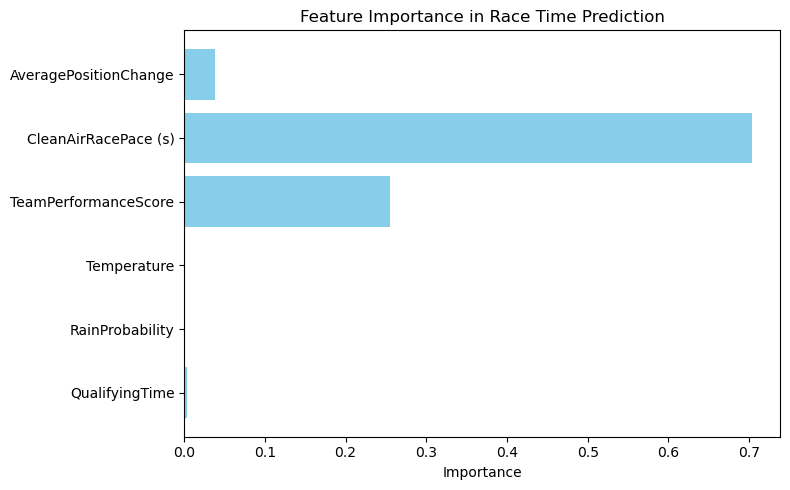

In [39]:
# Plot feature importances
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()

In [40]:
# sort results and get top 3
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
podium = final_results.loc[:2, ["Driver", "PredictedRaceTime (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")


🏆 Predicted in the Top 3 🏆
🥇 P1: LEC
🥈 P2: VER
🥉 P3: PIA
